In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

from datetime import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

calculate_binary = False

# Configuration Parameter

In [96]:
data_lan_code = 'DE'

filter_countries = True
filter_languages = False # Resource intensive, use with care

#limit_method = 'count'
#limit_method = 'percent'
limit_method = None
max_tag_count = 100
max_tag_percent = 0.5

# Always applied after tag limit calculation
filter_tags_by_usage = True
min_tag_usage = 20

# Read data

In [97]:

df = pd.read_csv('../data/'+ data_lan_code + 'videos.csv')

# Calculate categories

In [98]:
def assign_trending_category(row):
    if row['days_until_trending'] == 0:
        return 0 # 0 Days
    elif row['days_until_trending'] == 1:
        return 1 # 1 Day
    elif row['days_until_trending'] == 2:
        return 2 # 2 Days
    elif row['days_until_trending'] <= 5:
        return 3 # 3 - 5 Days
    else:
        return 4 # > 5 Days

df['days_until_trending'] = df.apply(lambda row: ((datetime.strptime(row['trending_date'], '%y.%d.%m') - datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z')).days + 1), axis=1)
df['trending_category'] = df.apply(assign_trending_category, axis=1)

# Drop unused data

In [99]:
df = df.drop(['trending_date','category_id', 'publish_time', 'views', 'likes','dislikes',
         'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled',
         'video_error_or_removed', 'description', 'days_until_trending',
          'channel_title'], axis=1)
df.head()

,video_id,title,tags,trending_category
0,LgVi6y5QIjM,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",1
1,Bayt7uQith4,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",2
2,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,"last week tonight trump presidency|""last week ...",1
3,AHtypnRk7JE,Das Fermi-Paradoxon,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",2
4,ZJ9We4bjcg0,18 SONGS mit Kelly MissesVlog (Sing-off),"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",2


## Parse tags and convert

Breaks the tag-strings into single elements and formats them. The following formatting is applied:
* Remove enclosing quotation marks ("")
* convert to lower case
* remove all duplicates (due to conversion to lower)

After formatting, the tags are filter by the following rules. The tag will be excluded when:
* The tag matches the '[none]' tag
* The tag is a number (to remove time related data)
* The tag describes a country
* The tag describes a language (resource intensive due to large amount of languages)

In [100]:

countries = [s.name for s in pycountry.countries]
languages = [s.name for s in pycountry.languages]

def isValidTag(s):
    return s != '[none]' \
    and not s.isnumeric() \
    and not(filter_countries and s in countries) \
    and not (filter_languages and s in languages)
def formatData(s):
    s2 = map(lambda x: x.strip('\"').lower(), s)
    res = []
    [res.append(x) for x in s2 if x not in res]
    return res

df['parsed_tags'] = df['tags'].str.split('|')\
    .apply(formatData)\
    .apply(lambda x: list(filter(isValidTag, x)))
df = df.drop('tags', axis=1)
df['parsed_tags'].head()


0    [inscope21, sing zu ende, gesangseinlagen, ges...
1    [kinder, ferngesteuert, kinder ferngesteuert, ...
2    [last week tonight trump presidency, last week...
3    [physik, wissenschaft, technik, science-fictio...
4    [kelly, missesvlog, kelly song, bausa, bausa w...
Name: parsed_tags, dtype: object

## Calculate tag count per video

In [101]:
df['tag_count'] = df.apply( lambda row: len(row['parsed_tags']), axis=1)
df.head()

,video_id,title,trending_category,parsed_tags,tag_count
0,LgVi6y5QIjM,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,1,"[inscope21, sing zu ende, gesangseinlagen, ges...",16
1,Bayt7uQith4,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,2,"[kinder, ferngesteuert, kinder ferngesteuert, ...",27
2,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,1,"[last week tonight trump presidency, last week...",4
3,AHtypnRk7JE,Das Fermi-Paradoxon,2,"[physik, wissenschaft, technik, science-fictio...",9
4,ZJ9We4bjcg0,18 SONGS mit Kelly MissesVlog (Sing-off),2,"[kelly, missesvlog, kelly song, bausa, bausa w...",5


## Calculate total tag counts

In [102]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
tag_counts = to_1D(df['parsed_tags']).value_counts()
tag_counts.name = "counts"

## Display top 20 tags

d:\programme\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

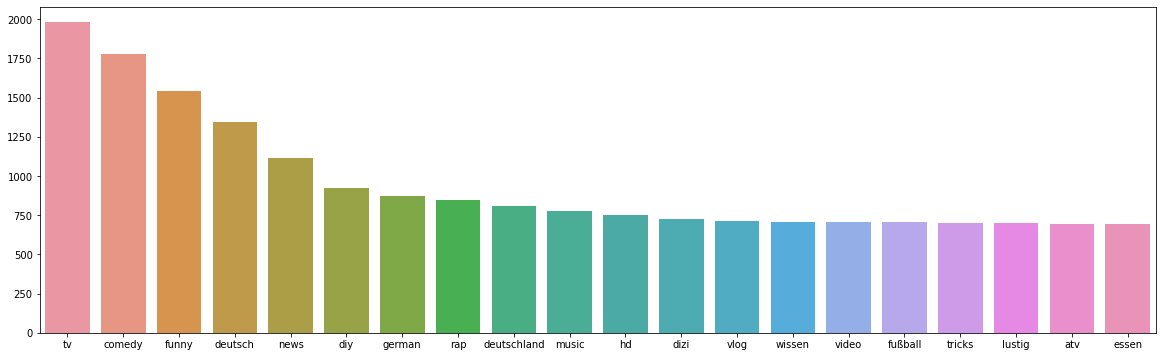

In [103]:
top_tags = tag_counts.head(20)
sns.barplot(top_tags.index, top_tags.values)

# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

## Convert tags into their own table

In [104]:
tags_df = df['parsed_tags'].apply(pd.Series)
tags_df.head()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,inscope21,sing zu ende,gesangseinlagen,gesang,gesungen,songs nachsingen,nachsingen,songs covern,carpool karaoke,witziger gesang,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,kinder,ferngesteuert,kinder ferngesteuert,luke mockridge kinder,luke die woche und ich kinder,prank,verarschen,kiosk,funkgerät,falschgeld,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,last week tonight trump presidency,last week tonight donald trump,john oliver trump,donald trump,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,physik,wissenschaft,technik,science-fiction,außerirdische,alien,aliens,fermi,fermi-paradoxon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,kelly,missesvlog,kelly song,bausa,bausa was du liebe nennst,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate tag usage

In [105]:
tags_df.iloc[:, 0].value_counts(normalize=True)

atv                             0.009257
çukur                           0.006242
fox                             0.005501
fußball                         0.004787
шарий                           0.004734
                                  ...   
amal arafa                      0.000026
exatlon romania (16.04.2018)    0.000026
primärfarben                    0.000026
rb leipzig                      0.000026
alicia spinnet                  0.000026
Name: 0, Length: 9978, dtype: float64

## Convert tags to binary table

In [106]:
def boolean_df(item_lists, items):
    bool_dict={}
    for i, item in enumerate(items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

tags_start = 0
tags_end = 1000
if calculate_binary:
    #unique_items = tag_counts.where(lambda x: x > 500).dropna().index
    unique_items = tag_counts.head(tags_end).tail(tags_end-tags_start).index
    head_tags = df['parsed_tags']
    tags_bool = boolean_df(head_tags, unique_items)
    tags_bool.head()

## Tags as correlation matrix

In [107]:
if calculate_binary:
    tags_int = tags_bool.astype(int)
    tags_freq_mat = np.dot(tags_int.T, tags_int)
    np.fill_diagonal(tags_freq_mat, 0)

    tags_freq = pd.DataFrame(tags_freq_mat, columns = unique_items, index = unique_items)

    fix, ax = plt.subplots(figsize = (9,5))
    sns.heatmap(tags_freq, cmap = "Blues")
    plt.xticks(rotation=50)
    #plt.savefig("heatmap.png", dpi = 300)



# Calculate Tag factors
## Gather Tag Data

In [108]:
factors = {
    0 : 1.0,
    1 : 0.75,
    2 : 0.5,
    3 : 0.25,
    4 : 0.0
}

tag_index = {}
for index, row in df.iterrows():
    cat = row['trending_category']
    trending_value = factors[cat]
    for tag in row['parsed_tags']:
        if tag in tag_index:
            tag_index[tag]['count'] += 1
            tag_index[tag]['sum'] += trending_value
        else:
            tag_index[tag] = { 'count': 1, 'sum': trending_value }

tag_data = pd.DataFrame.from_dict(tag_index, orient='index')
tag_data

,count,sum
inscope21,83,42.25
sing zu ende,14,6.50
gesangseinlagen,4,1.75
gesang,21,9.75
gesungen,15,6.75
...,...,...
невошедшие номера,1,0.75
смешные ляпы,1,0.75
уральские пельмени этого не было на тв,1,0.75
уральские пельмени то что не вошло в эфир,1,0.75


## Filter Data and calculate Factor

In [109]:
if limit_method == 'count':
    tag_factors = tag_data.head(max_tag_count)
elif limit_method == 'percent':
    tag_factors = tag_data.head(int(len(tag_data)*max_tag_percent))
else:
    tag_factors = tag_data.copy()

if filter_tags_by_usage:
    tag_factors = tag_factors[tag_factors['count'] >= min_tag_usage]

tag_factors['factor'] = tag_factors['sum'] / tag_factors['count']
tag_factors['tag_weight'] = tag_factors['factor'] * tag_factors['count']
tag_factors = tag_factors.sort_values(by='factor', ascending=False)
tag_factors


,count,sum,factor,tag_weight
full game,23,20.25,0.880435,20.25
split,20,17.25,0.862500,17.25
wellness,22,18.75,0.852273,18.75
neuer modus,24,20.25,0.843750,20.25
lcs,22,18.50,0.840909,18.50
...,...,...,...,...
kontra k neues video,27,11.00,0.407407,11.00
vfx,32,13.00,0.406250,13.00
shaho casado,26,10.50,0.403846,10.50
warner bros,28,11.25,0.401786,11.25


## Apply Tag factors

In [110]:
def calculate_tag_factor(data):
    tag_list = list()
    for t in data:
        factor = tag_factors['factor'].get(t, None)
        if factor is not None :
            tag_list.append(factor)
    return np.nan if len(tag_list) == 0 else np.mean(tag_list)
df['tag_factor'] = df['parsed_tags'].apply(calculate_tag_factor)

df[['title','tag_factor']]

,title,tag_factor
0,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,0.512928
1,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,0.612439
2,The Trump Presidency: Last Week Tonight with J...,0.686567
3,Das Fermi-Paradoxon,0.633594
4,18 SONGS mit Kelly MissesVlog (Sing-off),0.541702
...,...,...
40835,KINGDOM HEARTS III – E3 2018 Pirates of the Ca...,0.725610
40836,YMS: The Visit,NaN
40837,Ungut umgeschult – Grünwald als Ersthelfer am ...,0.661601
40838,Assassin's Creed Odyssey: E3 2018 Welt-Enthüll...,0.654359


### Remove entries with no value and sort by factor

In [111]:
target_videos = df[df['tag_factor'].notna()]
target_videos[['video_id','title','tag_factor', 'tag_count']].sort_values(by=['tag_factor'], ascending=False)

,video_id,title,tag_factor,tag_count
36468,nujkpx_I-F8,"10 gefährliche Beauty-Erfindungen, die der Ver...",0.814286,20
28203,axUt32vmdcM,Forscher haben endlich die ganze Wahrheit über...,0.814286,14
26919,T3tU-OTajlw,"12 versteckte Botschaften in berühmten Logos, ...",0.814286,10
35472,k6RMYTgWk-8,GS Warriors vs Houston Rockets - Full Game Hig...,0.794368,7
32426,89MA-LdPuQ8,Cleveland Cavaliers vs Toronto Raptors - Full ...,0.794368,8
...,...,...,...,...
27200,tUBMQsSNTPY,JIM KNOPF UND LUKAS DER LOKOMOTIVFÜHRER - Tra...,0.401786,16
26742,tUBMQsSNTPY,JIM KNOPF UND LUKAS DER LOKOMOTIVFÜHRER - Tra...,0.401786,16
34143,1I-eQH5Nbyg,DEEP BLUE SEA 2 - Trailer #1 Deutsch HD German...,0.401786,21
26592,tUBMQsSNTPY,JIM KNOPF UND LUKAS DER LOKOMOTIVFÜHRER - Tra...,0.401786,16


## Data coverage

In [112]:
len(target_videos.index) / len(df.index)

0.8511263467189031

## Save tag factors to csv

In [113]:
tag_data = tag_factors.copy()
tag_data['tags'] = tag_data.index
tag_data[['tags','factor','count']].to_csv('../data/'+data_lan_code+'tags.csv', header=['tag','factor','count'], index=False)

## Load Tags

In [114]:
tag_df = pd.read_csv('../data/'+data_lan_code+'tags.csv')
tag_df = tag_df.set_index('tag')
tag_df.head()

,factor,count
tag,,
full game,0.880435,23
split,0.862500,20
wellness,0.852273,22
neuer modus,0.843750,24
lcs,0.840909,22


## Converter function

In [115]:
def calculate_tag_factor(tag_string, tag_values):
    return pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))\
        .apply(lambda n: tag_values['factor'].get(n, np.nan))\
        .mean(skipna=True)

## Test function

In [116]:
test_df = pd.read_csv('../data/'+data_lan_code+'videos.csv')
test_df = test_df.head(10) # Just use head to reduce runtime
test_df['tag_factors'] = test_df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
test_df[['video_id','title','channel_title','tags','tag_factors']]

,video_id,title,channel_title,tags,tag_factors
0,LgVi6y5QIjM,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,inscope21,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",0.512928
1,Bayt7uQith4,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,LUKE! Die Woche und ich,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",0.612439
2,1ZAPwfrtAFY,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,"last week tonight trump presidency|""last week ...",0.686567
3,AHtypnRk7JE,Das Fermi-Paradoxon,100SekundenPhysik,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",0.633594
4,ZJ9We4bjcg0,18 SONGS mit Kelly MissesVlog (Sing-off),rezo,"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",0.541702
5,xapGFgWqtg4,Geld verdienen mit Online-Umfragen? Geht das w...,Die Allestester,[none],NaN
6,EIM7RMe39JY,Kanaken auf der Klassenfahrt,Bodyformus,"kanaken|""kurden""|""türken""|""schule""|""schulzeit""...",0.590316
7,PaWTaj6Iie0,3 unbekannte Gesichter von Film/Serien-Charakt...,Jay & Arya,"unbekannte gesichte charakter|""unbekannte gesi...",0.526124
8,GHct2dGNLks,Antoine leiht Auto von Ernährungsberaterin,TeddyComedy,"Antoine Auto|""Antoine Boot Camp""|""Antoine Ernä...",0.602571
9,aZYSFByDGkg,Legenden: So wird dein Ruhm unsterblich - Fame...,WALULIS,"michael jackson|""promi""|""tot""|""tod""|""gestorben...",0.609751
